In [38]:
import os 
import random 
import time 

import ale_py 
import gymnasium as gym 
import numpy as np 
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torch.optim as optim  
from torch.distributions import Categorical 
from stable_baselines3.common.buffers import RolloutBuffer
from stable_baselines3.common.atari_wrappers import (
    ClipRewardEnv,
    EpisodicLifeEnv, 
    FireResetEnv, 
    MaxAndSkipEnv, 
    NoopResetEnv,
)
import matplotlib.pyplot as plt 


In [27]:
env_id = "BreakoutNoFrameskip-v4" 
num_envs = 16 
n_steps = 5 
total_timesteps = 2_000_000
learning_rate = 2e-4
gamma = 0.99
gae_lambda = 0.95 
seed = None
entropy_weight = 0.01 
value_weight = 0.25
max_norm = 0.5 
video_path = "videos_a2c_gae_atari" 



In [6]:
def make_env(env_id, capture_video, seed=None): 
    if capture_video: 
        env = gym.make(env_id, render_mode="rgb_array") 
        env = gym.wrappers.RecordVideo(env, "videos", episode_trigger=lambda e: True)
    else: 
        env = gym.make(env_id) 
    env = gym.wrappers.RecordEpisodeStatistics(env)
    env = NoopResetEnv(env, noop_max=30)
    env = MaxAndSkipEnv(env, skip=4)
    env = EpisodicLifeEnv(env)

    if "FIRE" in env.unwrapped.get_action_meanings(): 
        env = FireResetEnv(env)
    env = ClipRewardEnv(env)
    env = gym.wrappers.ResizeObservation(env, (84, 84))
    env = gym.wrappers.GrayscaleObservation(env)
    env = gym.wrappers.FrameStackObservation(env, 4)

    if seed is not None: 
        env.action_space.seed(seed)
    return env 
        

In [30]:
class ActorCritic(nn.Module): 
    def __init__(self, envs):
        super().__init__() 
        n_input_channels = envs.single_observation_space.shape[0]  
        self.cnn = nn.Sequential( 
            nn.Conv2d(n_input_channels, 32, kernel_size=8, stride=4, padding=0), 
            nn.ReLU(), 
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=0), 
            nn.ReLU(), 
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0), 
            nn.ReLU(), 
            nn.Flatten(), 
        ) 
          
        # Compute shape by doing a forward pass 
        with torch.no_grad(): 
            n_flatten = self.cnn(
                torch.as_tensor(
                    envs.single_observation_space.sample()[None]).float()).shape[1]
                
        self.linear = nn.Sequential(
            nn.Linear(n_flatten, 512), 
            nn.ReLU()
        )

        # Actor (Policy) Head 
        self.actor = nn.Linear(512, envs.single_action_space.n)

        # Critic (Value) Head 
        self.critic = nn.Linear(512, 1)

    def forward(self, x): 
        features = self.cnn(x / 255.0) 
        shared_latent = self.linear(features) 
        return self.actor(shared_latent), self.critic(shared_latent) 
            
        

In [8]:
envs = gym.vector.SyncVectorEnv([
    lambda: make_env(
        env_id, 
        False, 
        None if seed is None else seed + i) for i in range(num_envs) 
], autoreset_mode=gym.vector.AutoresetMode.SAME_STEP) 

A.L.E: Arcade Learning Environment (version 0.11.2+ecc1138)
[Powered by Stella]


In [9]:
if seed is not None: 
    torch.manual_seed(seed) 
    random.seed(seed) 
    np.random.seed(seed) 
    if torch.cuda.is_available(): 
        torch.backends.cudnn.deterministic = True  


In [10]:
device = torch.device(
    "cuda" if torch.cuda.is_available() else 
    "mps" if torch.backends.mps.is_available() else 
    "cpu"
) 



In [31]:
ac_network = ActorCritic(envs).to(device) 
optimizer = optim.Adam(ac_network.parameters(), lr=learning_rate, eps=1e-5) 

In [ ]:
rollout_buffer = RolloutBuffer(
    buffer_size=n_steps, 
    observation_space=envs.single_observation_space, 
    action_space=envs.single_action_space, 
    device=device, 
    gamma=gamma, 
    gae_lambda=gae_lambda, 
    n_envs=num_envs, 
)

In [19]:
# sample an action from logits 
def sample_action(logits): 
    dist = Categorical(logits=logits) 
    return dist.sample() 

# compute entropy for loss regularization 
def compute_entropy_and_log_prob(logits, actions): 
    dist = Categorical(logits=logits) 
    entropy = dist.entropy() 
    log_probs = dist.log_prob(actions) 
    return entropy.mean(), log_probs

In [20]:
def np2torch(x, dtype=torch.float32, device=device):
    return torch.as_tensor(x, dtype=dtype, device=device ) 

In [ ]:
episode_returns = []
losses = [] 
global_step = 0  
start_time = time.time()  

# Reset buffer before first use
rollout_buffer.reset()

# reset envs 
obs, _ = envs.reset(seed=seed)

while global_step < total_timesteps: 
    # Rollout phase 
    for step in range(n_steps): 
        # Convert obs to tensor 
        obs_tensor = np2torch(obs) 
        # Forward pass through the network 
        with torch.no_grad():  
            policy_logits, values = ac_network(obs_tensor)  
            actions = sample_action(policy_logits) 
            _, log_probs = compute_entropy_and_log_prob(policy_logits, actions) 

        # Take action 
        actions_np = actions.cpu().numpy() 
        next_obs, rewards, terminateds, truncateds, infos = envs.step(actions_np) 
        dones = terminateds | truncateds 

        # Store data in buffer
        rollout_buffer.add(
            obs, 
            actions_np, 
            rewards, 
            terminateds, 
            values.flatten(), 
            log_probs
        )

        # Update obs 
        obs = next_obs 

        for i, (terminated, truncated) in enumerate(zip(terminateds, truncateds)): 
            if terminated or truncated: 
                if 'episode' in infos['final_info']: 
                    ret = infos['final_info']['episode']['r'][i]
                    episode_returns.append(ret)
                    print(f"global_step={global_step}, episode={len(episode_returns)}, episode_return={ret}")
   
    # Update phase 
    with torch.no_grad(): 
        _, last_values = ac_network(np2torch(next_obs))  
        last_dones = dones 
         
    rollout_buffer.compute_returns_and_advantage(last_values.flatten(), last_dones) 

    # This will only loop once (get all data in one go)
    for rollout_data in rollout_buffer.get(batch_size=None):
        observations_arr = rollout_data.observations
        actions_arr = rollout_data.actions
        advantages_arr = rollout_data.advantages 
        returns_arr = rollout_data.returns 

        # Calculate 
        new_logits, new_values = ac_network(observations_arr)
        entropy, new_log_probs = compute_entropy_and_log_prob(new_logits, actions_arr)
        new_values = new_values.flatten() 

        # Value loss (MSE)
        value_loss = F.mse_loss(new_values, returns_arr)

        # Policy loss
        policy_loss = -(advantages_arr * new_log_probs).mean() 

        # Entropy loss 
        entropy_loss = -entropy

        # Total loss 
        loss = policy_loss + value_weight * value_loss + entropy_weight * entropy_loss  
        losses.append(loss.item()) 
        # Update network 
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(ac_network.parameters(), max_norm)
        optimizer.step() 

        
    # Reset buffer 
    # If you don't reset, observations will have the wrong shape
    # It flattens from (N, num_envs, 4, 84, 84) to (N * num_envs, 4, 84, 84)
    rollout_buffer.reset() 

    # Update global step 
    global_step += n_steps * num_envs 

    if global_step % (100 * n_steps * num_envs) == 0 and len(episode_returns) > 100: 
        print(f"Global Step: {global_step} / {total_timesteps}")
        print(f"  Loss: {loss.item():.4f} (Policy: {policy_loss.item():.4f}, Value: {value_loss.item():.4f}, Entropy: {entropy_loss.item():.4f})")
        if episode_returns: 
            print(f"  Mean return (last 100): {np.mean(episode_returns[-100:]):.2f}")
        print("steps per second:", int(global_step / (time.time() - start_time)))
    
envs.close()
            



global_step=0, episode=1, episode_return=0.0
global_step=80, episode=2, episode_return=5.0
global_step=80, episode=3, episode_return=0.0
global_step=240, episode=4, episode_return=0.0
global_step=240, episode=5, episode_return=0.0
global_step=400, episode=6, episode_return=0.0
global_step=560, episode=7, episode_return=0.0
global_step=560, episode=8, episode_return=0.0
global_step=560, episode=9, episode_return=0.0
global_step=560, episode=10, episode_return=2.0
global_step=720, episode=11, episode_return=0.0
global_step=880, episode=12, episode_return=0.0
global_step=960, episode=13, episode_return=1.0
global_step=960, episode=14, episode_return=1.0
global_step=960, episode=15, episode_return=0.0
global_step=1120, episode=16, episode_return=0.0
global_step=1120, episode=17, episode_return=0.0
global_step=1600, episode=18, episode_return=1.0
global_step=1840, episode=19, episode_return=0.0
global_step=1840, episode=20, episode_return=0.0
global_step=2080, episode=21, episode_return=0.0

In [36]:
def smooth(x, a=0.1):
    y = [x[0]]
    for xi in x[1:]: 
        yi = a * xi + (1 - a) * y[-1]
        y.append(yi)
    return y




Text(0.5, 1.0, 'Episode Returns')

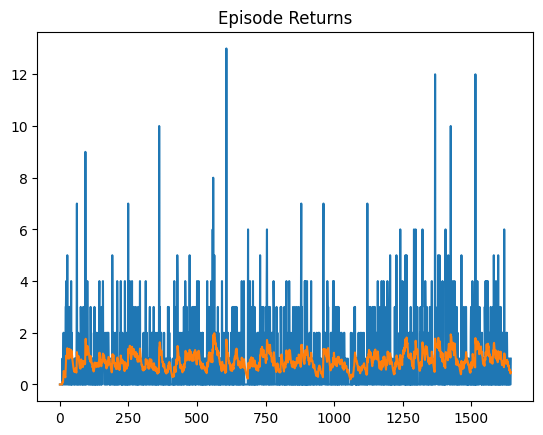

In [39]:
plt.plot(episode_returns)
plt.plot(smooth(episode_returns))
plt.title("Episode Returns") 


In [ ]:
# Save model 
model_path = "models/a2c_atari.pth" 
torch.save(ac_network.state_dict(), model_path) 

In [ ]:
# Evaluation 
envs_eval = gym.vector.SyncVectorEnv([lambda: make_env(env_id, True)], autoreset_mode=gym.vector.AutoresetMode.SAME_STEP)
model = ActorCritic(envs_eval).to(device) 
model.load_state_dict(torch.load(model_path)) 
model.eval() 


In [ ]:
n_episodes = 10  
eval_returns = np.zeros(n_episodes) 
obs, _ = envs_eval.reset()
for i in range(n_episodes): 
    episode_done = False 
    while not episode_done:  
        with torch.no_grad(): 
            policy_logits, values = model(np2torch(obs)) 
            actions = sample_action(policy_logits) 
            actions = actions.cpu().numpy() 
            obs, rewards, terminateds, truncateds, infos = envs_eval.step(actions) 
            episode_done = terminateds | truncateds 
            if episode_done: 
                if 'final_info' in infos: 
                    if 'episode' in infos['final_info']: 
                        ret = infos['final_info']['episode']['r'][0] 
                        eval_returns[i] = ret 
                        print(f"episode={i}, return={ret}")
envs_eval.close() 
        